In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [11]:
# Set paths
data_dir = 'C:\\Toxic_Plants_Dataset_resized\\Toxic_Plants_Dataset_resized'

# Parameters
batch_size = 32
img_height = 224
img_width = 224
num_folds = 5
epochs = 10

In [12]:
# Load data
dataset = image_dataset_from_directory(
    data_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)

# Get class names
class_names = dataset.class_names
num_classes = len(class_names)

Found 6245 files belonging to 10 classes.


In [13]:
# Extract images and labels from the dataset
images, labels = [], []
for image_batch, label_batch in dataset:
    images.append(image_batch.numpy())
    labels.append(label_batch.numpy())
images = np.concatenate(images)
labels = np.concatenate(labels)

# K-Fold Cross-Validation
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=123)
fold_no = 1
acc_per_fold = []
val_acc_per_fold = []
test_acc_per_fold = []
loss_per_fold = []

In [14]:
for train, test in kfold.split(images, labels):
    print(f'Training fold {fold_no} ...')

    # Split train into actual train and validation
    val_split = int(len(train) * 0.2)
    train_data = train[val_split:]
    val_data = train[:val_split]

    # Create the model
    base_model = EfficientNetB0(input_shape=(img_height, img_width, 3),
                                include_top=False,
                                weights='imagenet')
    base_model.trainable = False  # Freeze the base model

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

Training fold 1 ...
Training fold 1 ...
Training fold 1 ...
Training fold 1 ...
Training fold 1 ...


In [16]:
# Train the model
history = model.fit(images[train_data], labels[train_data], 
                        epochs=epochs, 
                        batch_size=batch_size, 
                        validation_data=(images[val_data], labels[val_data]))


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 109s 801ms/step - accuracy: 0.4509 - loss: 1.6761 - val_accuracy: 0.7538 - val_loss: 0.8667
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 99s 792ms/step - accuracy: 0.7745 - loss: 0.8084 - val_accuracy: 0.8078 - val_loss: 0.6916
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 109s 877ms/step - accuracy: 0.8281 - loss: 0.6315 - val_accuracy: 0.8218 - val_loss: 0.6129
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 109s 875ms/step - accuracy: 0.8487 - loss: 0.5481 - val_accuracy: 0.8458 - val_loss: 0.5780
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 96s 768ms/step - accuracy: 0.8660 - loss: 0.4830 - val_accuracy: 0.8468 - val_loss: 0.5511
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 94s 750ms/step - accuracy: 0.8735 - loss: 0.4430 - val_accuracy: 0.8529 - val_loss: 0.5353
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 96s 771ms/step - accuracy: 0.8944 - loss: 0.3852 - val_accuracy: 0.8529 - val_loss: 0.5229
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 93s 746ms/step - accuracy: 0.8987 - loss

In [18]:
# Evaluate the model on the training set
train_loss, train_acc = model.evaluate(images[train_data], labels[train_data], verbose=0)
acc_per_fold.append(train_acc * 100)

In [19]:
 # Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(images[val_data], labels[val_data], verbose=0)
val_acc_per_fold.append(val_acc * 100)

In [20]:
 # Evaluate the model on the test set
scores = model.evaluate(images[test], labels[test], verbose=0)
print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
test_acc_per_fold.append(scores[1] * 100)
loss_per_fold.append(scores[0])

fold_no += 1

# Average scores
print(f'Average training accuracy over {num_folds} folds: {np.mean(acc_per_fold)}% (+- {np.std(acc_per_fold)})')
print(f'Average validation accuracy over {num_folds} folds: {np.mean(val_acc_per_fold)}% (+- {np.std(val_acc_per_fold)})')
print(f'Average test accuracy over {num_folds} folds: {np.mean(test_acc_per_fold)}% (+- {np.std(test_acc_per_fold)})')
print(f'Average loss over {num_folds} folds: {np.mean(loss_per_fold)}')

Score for fold 1: loss of 0.5240839719772339; compile_metrics of 85.0280225276947%
Average training accuracy over 5 folds: 93.31998825073242% (+- 0.0)
Average validation accuracy over 5 folds: 86.48648858070374% (+- 0.0)
Average test accuracy over 5 folds: 85.0280225276947% (+- 0.0)
Average loss over 5 folds: 0.5240839719772339


In [21]:
# Plot ROC Curve and Confusion Matrix for the last fold
predictions = model.predict(images[test])
pred_labels = np.argmax(predictions, axis=1)

# Classification report and confusion matrix
print(classification_report(labels[test], pred_labels, target_names=class_names))
conf_matrix = confusion_matrix(labels[test], pred_labels)
print(conf_matrix)

40/40 ━━━━━━━━━━━━━━━━━━━━ 28s 666ms/step
                    precision    recall  f1-score   support

     Angel Trumpet       0.84      0.84      0.84       140
       Castor Bean       0.78      0.79      0.79       105
            Cicuta       0.96      0.93      0.94       124
            Datura       0.80      0.81      0.81       149
       English Yew       0.89      0.92      0.91       145
          Foxglove       0.87      0.88      0.88       163
Lily of the Valley       0.89      0.90      0.89       140
        Manchineel       0.79      0.70      0.74        74
        Rosary Pea       0.80      0.72      0.76        57
   White Snakeroot       0.82      0.84      0.83       152

          accuracy                           0.85      1249
         macro avg       0.84      0.83      0.84      1249
      weighted avg       0.85      0.85      0.85      1249

[[118   3   0  12   2   1   2   0   0   2]
 [  3  83   0   3   6   2   0   1   1   6]
 [  0   1 115   1   1   0   0

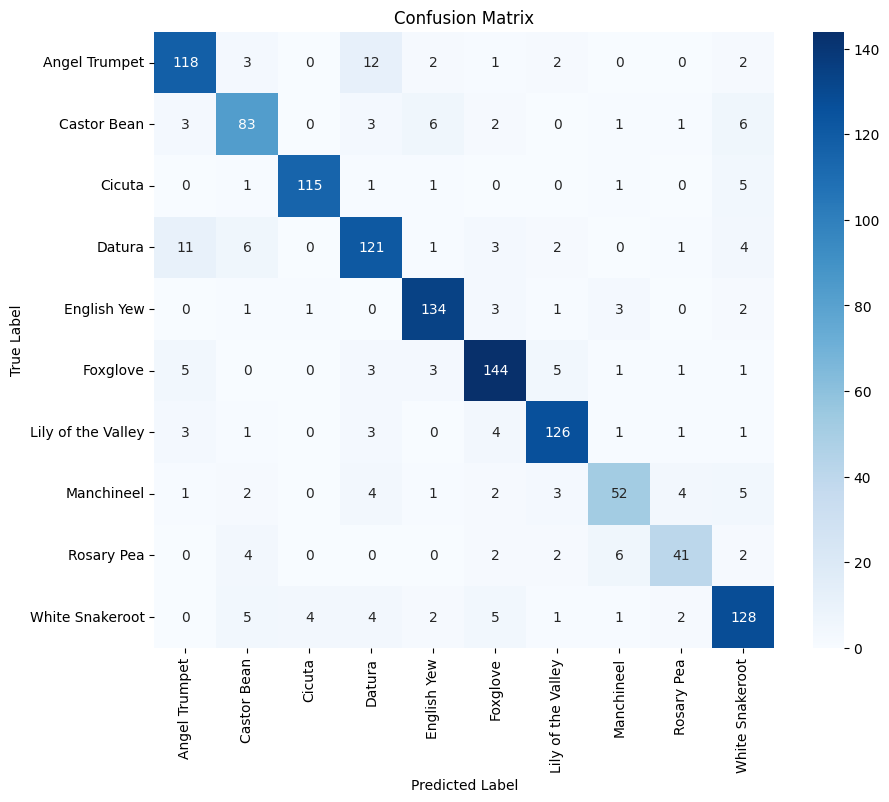

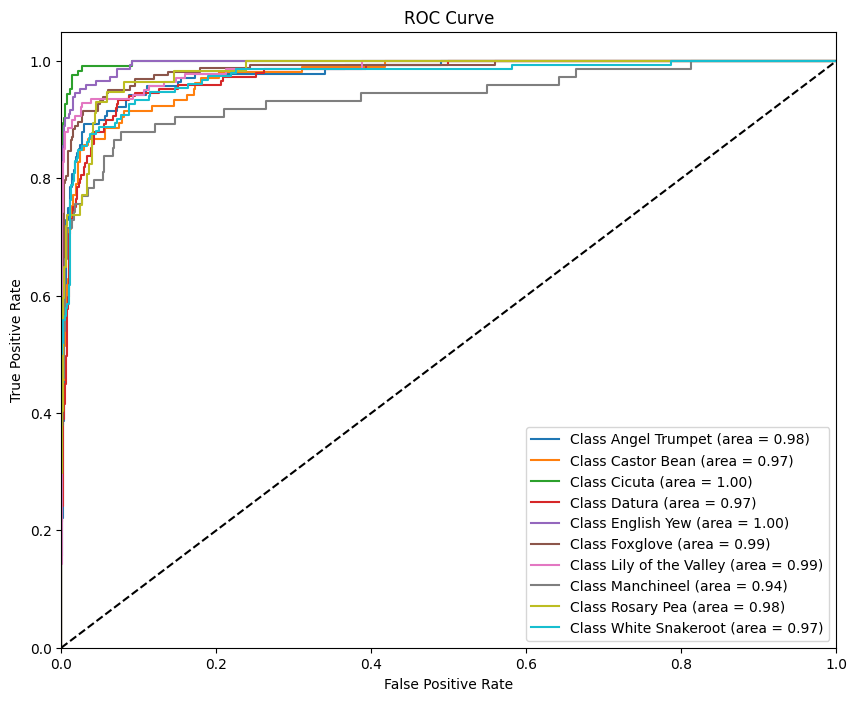

In [23]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix_after.png')
plt.show()

# Plot ROC curve for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(labels[test] == i, predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {class_names[i]} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.savefig('roc_curve_after.png')
plt.show()